In [ ]:
import random
from functools import reduce, partial
from pathlib import Path
from urllib.request import urlretrieve
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torcheval.metrics as tem
import fastcore.all as fc

Transformers were introduced in a paper called *Attention is all you need* in 2017 by Vaswani et al, and as the title suggests focusses heavily on a something called *attention*. This architecture is still very much in use today and is used in applications like ChatGPT, but also in other fields such as vision, audio and other sequence based fields such as protein folding.

Let's discuss the transformer architecture in terms of a word level model trying to predict the next word in a sequence. With a vocabulary of size 100, some tokenized sentence of the training set might look like this:

In [ ]:
len_vocab = 100

random.seed(42)
x_enc = [random.randint(0, len_vocab-1) for i in range(4)]
x_enc

[81, 14, 3, 94]

From this sequence we could naively create the following training samples:

In [ ]:
print(f'{"input".ljust(5)} -> output')
print(f'{"-"*15}')
for i in range(len(x_enc) - 1):
    print(f'{x_enc[i].__repr__().ljust(5)} -> {x_enc[i+1]}')

input -> output
---------------
81    -> 14
14    -> 3
3     -> 94


This is essentially the bigram language model, in which only the previous token is used to predict the next. 

Now let's consider the general case in which for each prediction we can use the full history of tokens, we then get the following samples:

In [ ]:
print(f'{"input".ljust(12)} -> output')
print(f'{"-"*22}')
for i in range(len(x_enc) - 1):
    print(f'{x_enc[:i+1].__repr__().ljust(12)} -> {x_enc[i+1]}')

input        -> output
----------------------
[81]         -> 14
[81, 14]     -> 3
[81, 14, 3]  -> 94


As we progress further into the sequence we can use more *context* from the sequence to predict the next token. For the first sample we just have one single token for the prediction, for the last sample we can use 3 tokens for our prediction. The question is then: *how do we use this varying length context in an optimal way to make the best prediction for the next word?*

The initial idea we will pursue is to 

1. turn the tokens into embeddings, and
2. average the embeddings of the tokens in the context

Arguably, this is a pretty rough way of dealing with the information contained in the individual embeddings. And indeed, we will see that self-attention is a bit more involved than this. However, it's a good starting point to understand self-attention.

If we represent an embedding vector of token $x$ as `E_[x]` and the average of two embedding vectors $x$ and $y$ as `E_[x,y]` we can visualize our training samples as:

In [ ]:
print(f'{"raw input".ljust(10)} -> {"embedded input".ljust(16)} -> {"avg embedded input".ljust(19)} -> output')
print(f'{"-"*62}')
for i in range(len(x_enc) - 1):
    print(f'{x_enc[i].__repr__().ljust(10)} -> E_{x_enc[i].__repr__().ljust(14)} -> E_{x_enc[:i+1].__repr__().ljust(17)} -> {x_enc[i+1]}')

raw input  -> embedded input   -> avg embedded input  -> output
--------------------------------------------------------------
81         -> E_81             -> E_[81]              -> 14
14         -> E_14             -> E_[81, 14]          -> 3
3          -> E_3              -> E_[81, 14, 3]       -> 94


So, let's start with the first transformation, the creation of embedding vectors for the raw (integer) inputs:

In [ ]:
n_emb = 3

Emb = nn.Embedding(num_embeddings=len_vocab, embedding_dim=n_emb)

With the help of this embedding layer, the inputs now look like this:

In [ ]:
embs = Emb(torch.tensor(x_enc[:-1]))
embs

tensor([[-2.0403,  1.1378,  0.9802],
        [-0.7750, -0.4696, -1.0610],
        [ 0.9879, -0.3349, -0.5499]], grad_fn=<EmbeddingBackward0>)

In other words, we have the mapping:

In [ ]:
print(f'{"raw input".ljust(13)} -> embedding vector')
print(f'{"-"*43}')
for i, v in zip(x_enc, embs):
    print(f'{i.__repr__().ljust(13)} -> {[round(i,4) for i in v.tolist()]}')

raw input     -> embedding vector
-------------------------------------------
81            -> [-2.0403, 1.1378, 0.9802]
14            -> [-0.775, -0.4696, -1.061]
3             -> [0.9879, -0.3349, -0.5499]


Now that we have a 2d tensor in which the individual embeddings are stacked vertically, we want to create a new tensor that represents the *running average of all the embeddings in the rows that came before it*. In other words, we now want a vertically stacked tensor consisting of `[E_[81], E_[81, 14], E_[81, 14, 3]]`:

`E_[81]`:

In [ ]:
#| code-fold: true
embs[0].data

tensor([-2.0403,  1.1378,  0.9802])

`E_[81, 14]`:

In [ ]:
#| code-fold: true
embs[0:2].mean(dim=0).data

tensor([-1.4077,  0.3341, -0.0404])

`E_[81, 14, 3]`:

In [ ]:
#| code-fold: true
embs[0:3].mean(dim=0).data

tensor([-0.6092,  0.1111, -0.2102])

And the full tensor:

In [ ]:
#| code-fold: true
torch.stack([embs[0], embs[:-1].mean(dim=0), embs.mean(dim=0)])

tensor([[-2.0403,  1.1378,  0.9802],
        [-1.4077,  0.3341, -0.0404],
        [-0.6092,  0.1111, -0.2102]], grad_fn=<StackBackward0>)

Below, we will dive into the details on how to efficiently create these kind of tensors making use of matrix multiplications.

## Summation and averaging of vectors

Since *an average* involves taking the sum followed by a normalization, let's start with the summation.

Instead of calling `.sum()` on a vector, we can do a matrix multiplication with a vector consisting of ones (1's). This is essentially a *dot-product* of the two vectors, and since one of the vectors is filled with 1's we are just simply summing over the elements in the other vector:

In [ ]:
arr = torch.tensor(range(5), dtype=torch.float32)
arr

tensor([0., 1., 2., 3., 4.])

In [ ]:
sum_op = torch.ones(5)
sum_op

tensor([1., 1., 1., 1., 1.])

The matrix multiplication `arr @ sum_op` (dot-product) between these vectors evaluates as:

In [ ]:
#| code-fold: true
print("dot product between vectors:")
print(f'{[round(i) for i in arr.tolist()]} and {[round(i) for i in sum_op.tolist()]}:', end='\n\n')
out = []
for weight, value in zip(sum_op, arr):
    out.append(f'({value:.0f} x {weight:.0f})')
print(" + ".join(out) + f' = {arr@sum_op:.0f}')

dot product between vectors:
[0, 1, 2, 3, 4] and [1, 1, 1, 1, 1]:

(0 x 1) + (1 x 1) + (2 x 1) + (3 x 1) + (4 x 1) = 10


With this sum, we compute the average by dividing through the number of elements $n$:

In [ ]:
average = (arr @ sum_op) / sum_op.sum()
print(f'Average of array: {average:.0f}')

Average of array: 2


Equivalently, we could also pull the division into the `sum_op` itself, by doing:

In [ ]:
avg_op = sum_op / sum_op.sum()
avg_op

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

The matrix multiplication `arr @ avg_op` (dot-product) between these vectors evaluates as:

In [ ]:
#| code-fold: true
print("dot product between vectors:")
print(f'{[round(i) for i in arr.tolist()]} and {[round(i,1) for i in avg_op.tolist()]}:', end='\n\n')
out = []
for weight, value in zip(avg_op, arr):
    out.append(f'({value:.0f} x {weight:.1f})')
print(" + ".join(out) + f' = {arr@avg_op:.0f}')

dot product between vectors:
[0, 1, 2, 3, 4] and [0.2, 0.2, 0.2, 0.2, 0.2]:

(0 x 0.2) + (1 x 0.2) + (2 x 0.2) + (3 x 0.2) + (4 x 0.2) = 2


This second formulation (`avg_op`) gives rise to the concept of *weighted averages*, which would occur when we manipulate the values in the `avg_op` and thereby giving a different *weight* to each item in the array. When doing so, we ofcourse need to make sure the values sum to 1.

## Summation of matrices

To take the sum over matrices we can do something similar, but depending on the multiplication order and the shape of the matrix we can either sum over the columns or over the rows. Let's start with a matrix over which we want to compute the (row or column) sum:

In [ ]:
matrix = torch.tensor(range(0,6), dtype=torch.float32).view(3,2)
matrix

tensor([[0., 1.],
        [2., 3.],
        [4., 5.]])

And let's define the following `column_sum` matrix:

In [ ]:
#| code-fold: true
column_sum = torch.ones(3,3)
column_sum

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

The matrix multiplication `column_sum @ matrix` results in a matrix containing the column sum in each row, also note that the matrix has the same shape as the input matrix:

In [ ]:
#| code-fold: true
column_sum @ matrix

tensor([[6., 9.],
        [6., 9.],
        [6., 9.]])

If instead we multiply with the following matrix, we can take the sum over the rows:

In [ ]:
#| code-fold: true
row_sum = torch.ones(2,2)
row_sum

tensor([[1., 1.],
        [1., 1.]])

This time, the output matrix of `matrix @ row_sum` will hold the row sum in each column:

In [ ]:
#| code-fold: true
matrix @ row_sum

tensor([[1., 1.],
        [5., 5.],
        [9., 9.]])

Since we want to average the embeddings (which are stacked vertically) by dimension, we will need the `column_sum`. 

Next, we need to make sure that the first sample (row) only averages over the first row, the second sample (row) averages over the first and second row and the third sample (row) averages over the first three rows.

To achieve that, we can make use of the following matrix:

In [ ]:
sum_up_to = torch.tril(column_sum)
sum_up_to

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

This matrix is called a lower triangular matrix, as you can see all the values to the right of the diagonal are set to 0. When we multiply this with our matrix we get exactly what we need:

In [ ]:
matrix_sum_up_to = sum_up_to @ matrix
matrix_sum_up_to

tensor([[0., 1.],
        [2., 4.],
        [6., 9.]])

![samples from a sequence of tokens](sum_up_to.png){width=600}

In the diagram above, we look at the definition of the yellow highlighted cell. We see that multiplying the matrix this lower triangular matrix is indeed doing exactly what we need: it takes the sum up to the second row, because of the zero in cell `a23`, we dont add the value in the third row.

## Averaging of matrices

To go from sums to averages, we can do the same trick as for vectors: division by the row sum:

In [ ]:
avg_up_to = sum_up_to / sum_up_to.sum(dim=1, keepdims=True)
avg_up_to

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

As you can see, the rows still sum up to 1, and the non-zero weights are all equal: this means that we are now taking an average instead of a sum.

In [ ]:
matrix_avg_up_to = avg_up_to @ matrix
matrix_avg_up_to

tensor([[0., 1.],
        [1., 2.],
        [2., 3.]])

## Another way of creating an averaging operator matrix

Above we did some matrix gymnastics to understand how we can use matrix multiplication for the purpose of summation and averaging. Most notably, we saw how we can use a lower triangular matrix, to create *running* sums and averages over the rows of a matrix. For auto-regressive problems this is important, since we want to only use information of *things that happened until now*. 

As we will shortly see, *self-attention* doesn't just take simple averages over past embeddings, instead we want the model to be able to select *which parts of the past it finds interesting*. Mathematically this simply translates to the use of weighted averages, where the weights are going to be *data dependant*, e.g. learned by the model itself.

By doing so the `avg_op` will still be lower triangular (zeros in the top right corner) to ensure the auto-regressive property but it will have non-unique weights per row and thus represent a weighted average instead of a simple average.

To incorporate this, we will use another trick to create this `avg_up_to` matrix. We start with the `column_sum` matrix and fill the upper right elements with the largest negative value available: `-inf`:

In [ ]:
sum_up_to

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [ ]:
t = torch.ones(3,3) # --> column_sum
t.masked_fill_(sum_up_to == 0, -torch.inf)

tensor([[1., -inf, -inf],
        [1., 1., -inf],
        [1., 1., 1.]])

Next, we take the softmax along the row dimension:

In [ ]:
t.softmax(dim=1)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

:::{callout-note}
This works because taking the softmax means that we exponentiate everything and then normalize. Exponentiating `-torch.inf` returns 0, so the weight is distributed among the other values, since these other values are all the same ($e^1$) we get an equal weight distribution.
:::

So this results in the same exact matrix `avg_up_to` as we had before. This approach has the advantage however, that we can use a *general initial matrix*.

For example, for a *general initial matrix consisting of some random values*, we get to weighted averages:

In [ ]:
torch.manual_seed(2)
t = torch.randn(3,3)
t.masked_fill_(sum_up_to == 0, -torch.inf).softmax(dim=1)

tensor([[1.0000, 0.0000, 0.0000],
        [0.0954, 0.9046, 0.0000],
        [0.4257, 0.4122, 0.1622]])

If we consider the values in the above weighted average matrix: for the third sample (row 3) we see that a large weight is assigned to the first and second token, and less to the last token. The intuition being that for predicting the fourth token from the first three: the information of the first two tokens are more relevant then the information of the third token.

## Affinities and the dot-product

The next thing we need to discuss is ofcourse this *general initial matrix*. Where is this coming from? How do we construct it? For that, we need to have another look at the dot-product. As we saw above, the dot-product between two vectors is simply an element-wise multiplication, followed by a sum. 

We also saw that by carefully specifying one of the two vectors involved in the dot-product, we could make sure the output is either the sum or the average of the other vector. 

However, in general the dot-product between 2 vectors represents something like the *affinity* between the two vectors. The reason for this, is that there is a geometric interpretation which states that the dot-product between two vectors is equal to the multiplication of the length of both vectors and the cosine of the angle $\theta$ between the two vectors: $u \cdot v = |u| |v| \cos{\theta}$

The best intuition for this, comes from looking at 2D space and the following extreme cases:

1. vectors: `(1,0)` and `(1,0)`. These two vectors couldn't be more equal, there dot-product equals 1. 
2. vectors: `(1,0)` and `(0,1)`. These two vectors are geometrically orthogonal to one another, their dot-product is zero because the cosine of 90 degrees is zero.
3. vectors: `(1,0)` and `(-1,0)`. These two vectors point in opposite directions, the dot product is -1 since the cosine of 180 degrees is -1.

These intuitions translate to vectors of higher dimensionality, and we thus could get affinities betweeen tokens by taking the dot-product between embedding vectors. To do so, we matrix multiply the embeddings with it's transpose, so that each embedding vector (a single row in the `embs` matrix) gets a dot-product with each other row:

![](embs.png){width=600}

In [ ]:
affinity_matrix = embs @ embs.T
affinity_matrix.data

tensor([[ 6.4182,  0.0071, -2.9357],
        [ 0.0071,  1.9469, -0.0249],
        [-2.9357, -0.0249,  1.3905]])

You might guess where this is going: *we could use the affinity matrix as the general initial matrix* which we can use as a basis for creating the weighted averages matrix:

In [ ]:
sum_up_to = torch.tril(torch.ones(3,3))

affinity_matrix.masked_fill_(sum_up_to == 0, -torch.inf).softmax(dim=1).data

tensor([[1.0000, 0.0000, 0.0000],
        [0.1257, 0.8743, 0.0000],
        [0.0105, 0.1933, 0.7962]])

In fact, self-attention is doing almost exactly this. However, it's not computing affinities on the embeddings themselves, but on something called the query and the keys.

## Queries, Keys and Values

Now that we know how affinities work, let's continue with how these concepts are implemented in self-attention. Instead of using the embedding vectors as we have done above, self-attention works with three additional vectors: the query, key and value vector. All three vectors are simple (independant) linear transformation of the embedding vector. 

More specifically, the affinity matrix (previously computed as `embs @ embs.T` is going to be replaced by the multiplication of the query with the key matrix. The intuition here is that the query represents *the information of a token with respect to a certain query or question* and the key vector represents *the information the tokens contains.


To get some intuition on how this works, let's say that we need to predict what follows after encountering the single word "in". This is certainly difficult, it could be something like a country, for example *in Spain*, or *in Italy*. Or perhaps something related to time: *in the morning* or *in the evening*. Or it could be something like *in the box* or *in the closet*. It all depends on the context!

If we add some context it becomes much easier: "Last year I was on vacation in  ...". Now we immediately know that the first option (a country) is much more likely then the other two options (time and location/enclosure). 

The intuition is now, that the *query vector* of the word *in* is a representation of the question related to whether we are talking about a country, a time or a location/enclosure. And the key vectors of all the tokens represent whether they have any information on this. For example, the word "vacation" could emit a key that is similar to the query vector of "in", generating a high affinity between the tokens and thus resulting in a large weight.

The multiplication of the queries and the keys is thus what forms the affinity-matrix in self-attention. From this affinity-matrix the weighted averages matrix is computed in the way we have seen above (masking and softmax). You might expect that we then use this weighted averages matrix on our embeddings to get to weighted embeddings, but this is not the case. We don't directly average over the embeddings, instead we average the *values*. Similarly as for the query and key, this is just a linear transformation of the embedding itself.

The last thing which concludes attention is a normalization. As we have seen in an earlier [post](https://lucasvw.github.io/posts/11_nntrain_activations/#iterative-matrix-multiplications), the distribution of activations can shrink or increase by doing matrix multiplications. In the attention module, there is a scaling of the activations $1/\sqrt{d_k}$. This $d_k$ refers to the vector length of keys, values and queries, which is unique and is also referred to as the size of the (attention) head. after the multiplications of the keys and queries to make sure the distribution stays roughly standard normal. 

We can now understand the full formula for masked self-attention:

$$
\textrm{Masked Self Attention}(Q, K, V) = \textrm{softmax} \left( \frac{\textrm{mask}(QK^T)}{\sqrt{d_k}} \right) V
$$

## Masked Self Attention

Let's make a start with formalizing these things in code. Starting with some data:

In [ ]:
# code-fold: true

import random
from nntrain.dataloaders import DataLoaders
from nntrain.learner import *
from nntrain.activations import *
from nntrain.acceleration import *
from nntrain.rnn import *
########### Load the data ###########
path = Path('./data')
path.mkdir(parents=True, exist_ok=True)
path = path / 'names.txt'
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'

_ = urlretrieve(url, path)

with open(path, 'r') as f:
    lines = f.read().splitlines()
    
random.seed(42)
random.shuffle(lines)

train_size=0.8
val_size=0.1

train_lines = lines[0:int(train_size * len(lines))]
val_lines = lines[int(train_size * len(lines)): int((train_size + val_size) * len(lines))]

### Create vocabulary and mappings ###
unique_chars = list(set("".join(lines)))
unique_chars.sort()
vocabulary = ['.'] + unique_chars

c2i = {c:i for i, c in enumerate(vocabulary)}
i2c = {i:c for i, c in enumerate(vocabulary)}

class SequentialDataset():
    def __init__(self, lines, c2i, sequence_length):
        self.lines = lines
        self.c2i = c2i
        self.sequence_length = sequence_length
        self.shuffle_and_set_data()
    
    def shuffle_and_set_data(self):
        random.shuffle(self.lines)
        text = "." + ".".join(self.lines) + "."
        self.x = []
        self.y = []
        for i in range(0, len(text) - self.sequence_length - 1, self.sequence_length):
            self.x.append([self.c2i[xi] for xi in text[i: i+self.sequence_length]])
            self.y.append([self.c2i[yi] for yi in text[i+1: i+self.sequence_length+1]])
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.x)

def get_dls(context_length, batch_size):
    train_ds = SequentialDataset(train_lines, c2i, context_length)
    valid_ds = SequentialDataset(val_lines, c2i, context_length)
        
    train_dl = torch.utils.data.DataLoader(train_ds, shuffle=False, sampler=VerticalSampler(train_ds, batch_size), batch_size=batch_size, num_workers=4)
    valid_dl = torch.utils.data.DataLoader(valid_ds, shuffle=False, sampler=VerticalSampler(valid_ds, batch_size), batch_size=batch_size, num_workers=4)

    return DataLoaders(train_dl, valid_dl)

In [ ]:
sequence_length = 5
batch_size      = 8
dls = get_dls(sequence_length, batch_size)

In [ ]:
xb, yb = next(iter(dls.train))
xb.shape

torch.Size([8, 5])

The samples are thus in the same structure as we used for the RNN (and LSTM) models:

1. We have two dimensions in our training data: the first one being the batch dimension `B` and the second refers to a sequence of characters `T`. The `T` stands here for timestep, which is a strange name but is used for historical reasons.
2. The previous discussion on computing the rolling average over tensors only mentioned one of these dimensions: the sequence length dimension
3. Don't be confused by the batch dimension, it simply means we are processing each items in the batch in parallel. All the items in the batch are processed independantly from one another
3. We will see in the code, that we need to be pretty careful with these dimensions, to make sure the broadcasting rules of matrix multiplications are correctly applied

Let's create a `MaskedSelfAttentionHead` module. We initialize this module by creating the linear layers by which we can create the query, key and value vectors from our embeddings. Remind yourself that a linear layer applied to an embedding vector is simply a linear transformation of that vector into a new space (of dimension `head_size`).

We will also initialize the `mask` tensor consisting of a lower triangular matrix as a *buffer*. This makes sure that PyTorch will move this tensor to the appropriate device when moving the module, eventhough it's not treated as a module parameter (it's values are not optimized during training).

In [ ]:
class MaskedSelfAttentionHead(nn.Module):
    
    def __init__(self, emb_depth, head_size, sequence_length):
        super().__init__()
        self.queries = nn.Linear(emb_depth, head_size, bias=False)
        self.keys    = nn.Linear(emb_depth, head_size, bias=False)
        self.values  = nn.Linear(emb_depth, head_size, bias=False)
        
        self.register_buffer('mask', torch.tril(torch.ones(sequence_length, sequence_length)))

Next, let's have a closer look at the forward method of this module. The data passed to the forward module will consist of a batch of embedding data. We already saw that the raw input data is of shape `[B, T]`, once this data goes through an embedding layer it will be of shape: `[B, T, Ce]`, where `Ce` reflects the embedding depth.

From this data, we first compute the queries, keys and value vectors. Because of the shape of the linear layers, these three tensors are now of shape `[B, T, Ch]`.

As discussed, we want to compute the affinities between the queries and the keys which in the *single batch* case was computed as $QK^T$. Since we now also have a batch dimension, we only transpose the last two dimensions and the matrix multiplication is in fact a *batched matrix multiplication*.

These affinities are scaled, masked and softmaxed so that they represent weights. And finally the weights are applied to the batched values vector.

In [ ]:
@fc.patch()
def forward(self:MaskedSelfAttentionHead, x_emb):  # x_emb: [B, T, Ce]
    q = self.queries(x_emb)  # [B,T,Ch]
    k = self.keys(x_emb)     # [B,T,Ch]
    v = self.values(x_emb)   # [B,T,Ch]

    affinity = q @ k.transpose(-2, -1)  # [B,T,Ch] @ [B, Ch, T] -> [B, T, T]
    head_size = q.shape[-1]
    scaled_affinity = affinity / head_size**0.5
    masked_scaled_affinity = scaled_affinity.masked_fill_(self.mask == 0, -torch.inf)
    masked_weights = masked_scaled_affinity.softmax(dim=-1)

    masked_self_attention = masked_weights @ v # [B, T, T] @ [B,T,Ch] -> [B,T,Ch]

    return masked_self_attention # [B,T,Ch]

Our first transformer module is then very straight forward. Firstly, it will create embeddings for our input data, next it will compute the self-attention on these embeddings, and finally it will pass the self attention to a so-called *head*. This head is a simple linear layer which maps the activations to the right output size (the size of the vocabulary).

In [ ]:
class Transformer(nn.Module):
    
    def __init__(self, emb_depth, head_size, sequence_length):
        super().__init__()
        self.token_embedding = nn.Embedding(len(c2i), emb_depth)
        self.attention = MaskedSelfAttentionHead(emb_depth, head_size, sequence_length)
        self.head = nn.Linear(head_size, len(c2i))
        
    def forward(self, x):           # x: [B, T]
        x = self.token_embedding(x) # [B,T,Ce]
        x = self.attention(x)       # [B,T,Ch]
        x = self.head(x)            # [B,T,vocab]
        return x

In [ ]:
class Shuffle(Subscriber):
    def after_epoch(self, learn):
        learn.dls.train.dataset.shuffle_and_set_data()

epoch,mode,loss
0,train,2.911
0,eval,2.577
1,train,2.529
1,eval,2.497
2,train,2.482
2,eval,2.470
3,train,2.463
3,eval,2.459
4,train,2.457
4,eval,2.457


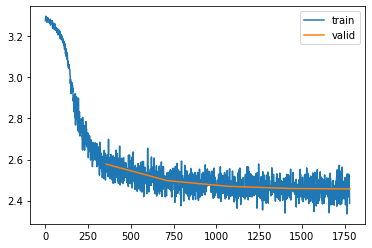

In [ ]:
# Train parameters
epochs = 5
lr     = 1e-3
bs     = 16

# Hyperparameters
sequence_length = 32
emb_depth       = 64
head_size       = 64

dls = get_dls(sequence_length, bs)
model = Transformer(emb_depth, head_size, sequence_length)

subs = [ProgressS(True),
        MetricsS(),
        DeviceS(device),
        Shuffle()]

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(model, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

The model seems to be training (the loss is going down), but it's not performing very well. Let's thus continue adding other components that are described in the paper:

## Positional embeddings

So far we created embeddings for our tokens and used them as the basis for the query, key and value vectors. However, in doing so we never explicitly encoded the *positional* information in the embeddings: we don't have any mechanism of working with the position of the tokens. Consider the sentence: *I was working at home when my cat ...*. Positional information is important to encode the fact that *cat* was mentioned after *I*. This way, the model might know that the words that will follow, will have to relate to my cat and not to me. There are multiple ways of encoding this positional information, but for now let's just stick with another embedding layer which will simply embed the position of each token in the sentence:

In [ ]:
class Transformer(nn.Module):
    
    def __init__(self, emb_depth, head_size, sequence_length):
        super().__init__()
        self.token_embedding = nn.Embedding(len(c2i), emb_depth)
        self.position_embedding = nn.Embedding(sequence_length, emb_depth)
        self.register_buffer('range', torch.arange(sequence_length))
        self.attention = MaskedSelfAttentionHead(emb_depth, head_size, sequence_length)
        self.head = nn.Linear(head_size, len(c2i))
        
    def forward(self, x):                     # x: [B,T]
        x_tok = self.token_embedding(x)       # [B,T,Ce]
        x_pos = self.position_embedding(x)    # [B,T,Ce]
        x = self.attention(x_tok + x_pos)     # [B,T,Ch]
        x = self.head(x)                      # [B,T,vocab]
        return x

## Multi-head attention

When introducing self-attention, we discussed one specific query that the token could be interested in, we computed the affinity of that query with all the keys of the tokens. It seems natural to assume that there are multiple queries to be formulated which would help with the prediction of the next token (What is the subject of the sentence? What is the tense? etc). Each possible query could naturally have an affinity with different tokens. These considerations give rise to *multi-head attention*. Multi-head attention is simply the application of multiple attention-heads in parallel and the concatentation of the results.

In [ ]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, emb_depth, head_size, n_heads, sequence_length):
        super().__init__()
        hs = head_size // n_heads
        if head_size % n_heads != 0:
            raise ValueError("head_size and n_heads don't match, make sure that head_size is divisible (without remainder) through n_heads")
        self.heads = nn.ModuleList([MaskedSelfAttentionHead(emb_depth, hs, sequence_length) for i in range(n_heads)])
        
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [ ]:
class Transformer(nn.Module):
    
    def __init__(self, emb_depth, head_size, n_heads, sequence_length):
        super().__init__()
        self.token_embedding = nn.Embedding(len(c2i), emb_depth)
        self.position_embedding = nn.Embedding(sequence_length, emb_depth)
        self.register_buffer('range', torch.arange(sequence_length))
        self.attention = MultiHeadAttention(emb_depth, head_size, n_heads, sequence_length)
        self.head = nn.Linear(head_size, len(c2i))
        
    def forward(self, x):
        x = self.token_embedding(x) + self.position_embedding(x)
        x = self.attention(x)
        x = self.head(x)
        return x

epoch,mode,loss
0,train,2.876
0,eval,2.524
1,train,2.486
1,eval,2.461
2,train,2.451
2,eval,2.441
3,train,2.436
3,eval,2.431
4,train,2.429
4,eval,2.429


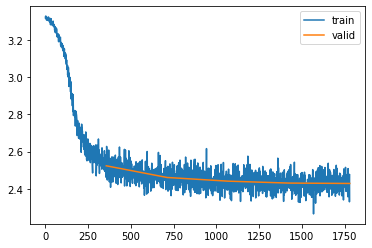

In [ ]:
# Hyperparameters
sequence_length = 32
emb_depth       = 64
head_size       = 64
n_heads         = 4

model = Transformer(emb_depth, head_size, n_heads, sequence_length)

l = Learner(model, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

## Multiple transformer blocks

The next improvement has to do with adding computation following the attention. Currently we are doing one layer of self-attention, followed by the head which maps the activations to the correct number of outputs (the size of the vocabulary). We want to change this by adding a feed forward network right after the attention module. The idea being that we want to add computation which allows the transformer to *think* upon the results from an attention block. As mentioned, this will just be a simple Linear layer followed by a ReLU:

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, emb_depth):
        super().__init__()
        self.net = nn.Sequential(*[
            nn.Linear(emb_depth, emb_depth),
            nn.ReLU(),
        ])
        
    def forward(self, x):
        return self.net(x)

And we create a transformerblock which couples the attention and computation phase:

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_depth, n_heads, sequence_length):
        super().__init__()
        self.att = MultiHeadAttention(emb_depth, emb_depth, n_heads, sequence_length)
        self.comp = FeedForward(emb_depth)
        
    def forward(self, x):
        att = self.att(x)
        comp = self.comp(att)
        return comp

We can now add another parameter `n_blocks` signifying how many of these sequential transformer blocks we want to have in the model:

In [ ]:
class Transformer(nn.Module):
    
    def __init__(self, emb_depth, n_heads, n_blocks, sequence_length):
        super().__init__()
        self.token_embedding = nn.Embedding(len(c2i), emb_depth)
        self.position_embedding = nn.Embedding(sequence_length, emb_depth)
        self.register_buffer('range', torch.arange(sequence_length))
        self.tblocks = nn.Sequential(*[TransformerBlock(emb_depth, n_heads, sequence_length) for i in range(n_blocks)])
        self.head = nn.Linear(emb_depth, len(c2i))
        
    def forward(self, x):
        x = self.token_embedding(x) + self.position_embedding(x)
        x = self.tblocks(x)
        x = self.head(x)
        return x

epoch,mode,loss
0,train,2.991
0,eval,2.811
1,train,2.623
1,eval,2.510
2,train,2.485
2,eval,2.462
3,train,2.444
3,eval,2.427
4,train,2.427
4,eval,2.419


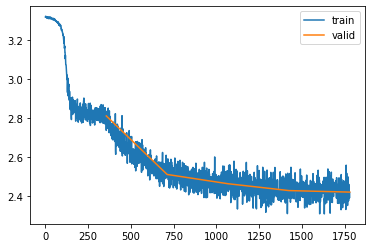

In [ ]:
# Hyperparameters
sequence_length = 32
emb_depth       = 64
n_heads         = 4
n_blocks        = 3

model = Transformer(emb_depth, n_heads, n_blocks, sequence_length)

l = Learner(model, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)

## Layernorm and Residual Connections

And finally we will add the skip connections and layer normalization. The way these are added is somewhat different from the paper. After the paper, one of the few improvements that were made on this architecture was the use of something called Pre-LN transformer, in which two layernorms are applied in the residual path before the attention and the computation respectively

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_depth, n_heads, sequence_length):
        super().__init__()
        self.att = MultiHeadAttention(emb_depth, emb_depth, n_heads, sequence_length)
        self.comp = FeedForward(emb_depth)
        self.ln1 = nn.LayerNorm(emb_depth)
        self.ln2 = nn.LayerNorm(emb_depth)
        
    def forward(self, x):
        att = x + self.att(self.ln1(x))
        comp = x + self.comp(self.ln1(att))
        return comp

epoch,mode,loss
0,train,3.073
0,eval,2.688
1,train,2.566
1,eval,2.494
2,train,2.462
2,eval,2.433
3,train,2.401
3,eval,2.373
4,train,2.360
4,eval,2.336


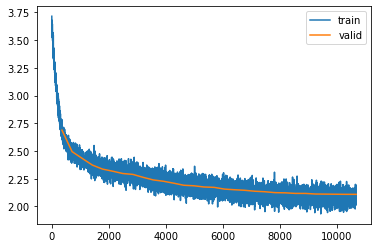

In [ ]:
# Hyperparameters
sequence_length = 32
emb_depth       = 64
n_heads         = 4
n_blocks        = 4

model = Transformer(emb_depth, n_heads, n_blocks, sequence_length)

epochs = 30

scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, epochs=epochs, steps_per_epoch=len(dls.train))

l = Learner(model, dls, multi_output_cross_entropy, torch.optim.Adam, None, subs=subs + [SchedulerS(scheduler)])
l.fit(epochs, lr=lr)